In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from scipy import interpolate


In [2]:


class GeneticAlgorithm():
    """
    Класс реализующий генетический алгоритм

    ...

    Methods
    -------
    estimate_fitness()
        метод оценки значения приспособленности
    crossover()
        оператор скрещивания
    mutation()
        оператор мутации
    keep_bounds()
        метод для выравнивания значений аргументов по заданным границам
    stop_criterion()
        метод с критериями останова
    run()
        метод для запуска оптимизации
    """
    
    def __init__(self,
                 opt_function,
                 num_args,
                 data,
                 population_size = 100,
                 crossover_rate = 0.5,
                 mutation_probability = 0.05,
                 max_num_iteration = 1e5,
                 max_num_iteration_without_improvement = 10,
                 tolerance = 1e-5,
                 args_bounds = None
                ):
                 
        """
        Parameters
        ----------
        opt_function : function
            оптимизируемая функция
        num_args : int
            количество аргументов у opt_function
        data : undefined
            данные необходимые для расчета функционала 
        population_size : int
            количество особей
        crossover_rate : float [0, 1]
            процент скрещивающихся особей
        mutation_probability : float [0, 1]
            вероятность мутации
        max_num_iteration : int or None
            максимальное количество итераций
        max_num_iteration_without_improvement : int
            максимальное количество последовательных итераций без улучшения результата
        tolerance : float
            минимальное значение уменьшения стандартного отклонения от best_score_history,  
            при котором продолжаются расчеты
        args_bounds : None or list of tuples
            содержит кортежи с мин и макс значениями для каждого аргумента opt_function
            если None, тогда выбираются стандартные границы
        best_score_history : list
            список с историей лучших результатов популяции на каждой итерации
        soltuion : dict
            словарь с аргументами и значением функции для лучшего решения
        """
        
        self.opt_function = opt_function
        self.num_args = num_args
        self.data = data
        self.population_size = population_size
        self.crossover_rate = crossover_rate
        self.mutation_probability = mutation_probability
        self.max_num_iteration = int(max_num_iteration)
        self.max_num_iteration_without_improvement = int(max_num_iteration_without_improvement)
        self.tolerance = tolerance
        self.args_bounds = args_bounds
        self.best_score_history = []
        self.solution = {}
        
        
    def estimate_fitness(self, x):
        """Метод оценивает приспособленность особи
        
        Parameters
        ----------
        x : np.array
            значения аргументов
            
        Returns
        ------
        score : float
            значение функции приспособленности
        """
        score = self.opt_function(x, self.data)
            
        return score
                 
    def crossover(self, x_parent, y_parent):
        """Метод для случайного скрещивания двух родительских особей, возвращает две потомственные особи
        
        Parameters
        ----------
        x_parent : np.array
            1ая родительская особь
        y_parent : np.array
            2ая родительская особь
            
        Returns
        ------
        x_child : np.array
            1ая потомственная особь
        y_child : np.array
            2ая потомственная особь
        """
        
        x_child = x_parent.copy()
        y_child = y_parent.copy()
                    
        for i in range(self.num_args):
            alpha = np.random.rand()
            x_child[i] = x_parent[i] + alpha * (y_parent[i] - x_parent[i])
            
            alpha = np.random.rand()
            y_child[i] = x_parent[i] + alpha * (x_parent[i] - y_parent[i])
                   
        return x_child, y_child
                 
    
    def mutation(self, x):
        """Метод для мутации особи меняет значения генов случайным образом
        
        Parameters
        ----------
        x : np.array
            значения аргументов
            
        Returns
        ------
        x_new : np.array
            новые значения аргументов        
        """
        
        x_new = x.copy()
        for i in range(self.num_args):
            if self.args_bounds is None:
                alpha = np.random.uniform(-1.0, 1.0)
            else:
                alpha = np.random.uniform(self.args_bounds[i][0], self.args_bounds[i][1])
            x_new[i] = x_new[i] + alpha
            
        return x_new
    
    
    
    def keep_bounds(self, x):
        """Метод ограничивает область значений аргументов
        
        Parameters
        ----------
        x : np.array
            значения аргументов
            
        Returns
        ------
        x_new : np.array
            новые значения аргументов        
        """
        
        x_new = x.copy()
        if self.args_bounds is None:
            return x_new
                       
        for i in range(self.num_args):
            # если x_i меньше минимума, тогда присваиваем значение минимума
            if x_new[i] < self.args_bounds[i][0]:
                x_new[i] = self.args_bounds[i][0]
            # если x_i больше максимума, тогда присваиваем значение максимума
            if x_new[i] > self.args_bounds[i][1]:
                x_new[i] = self.args_bounds[i][1]
            
        return x_new
           
        
    def stop_criterion(self, i):
        """В методе реализованы критерии останова
        
        Parameters
        ----------
        i : int
            номер итерации
            
        Returns
        ------
        True / False
            если хотя бы один из критериев срабатывает, то возвращает True        
        """
            
        # если стандартное отклонение best_score_history уменьшается меньше, чем на tolerance 
        rolling_std = [np.std(self.best_score_history[:i+1]) for i in range(3, len(self.best_score_history))]
        rolling_std = np.array(rolling_std)
        std_change = np.diff(rolling_std)[-1] / rolling_std[-2]
        if std_change < self.tolerance:
            print("std stop-criterion")
            return True
        
        # если количество итераций превышает максимальное
        if i > self.max_num_iteration - 1:
            print("max number of iteration stop-criterion")
            return True
        
        # если best_score не улучшается более max_num_iteration_without_improvement итераций
        n = self.max_num_iteration_without_improvement
        best_score_changes = np.sign(np.diff(self.best_score_history))[-n:]
        if not -1 in best_score_changes:
            print("max number of iteration without improvement stop-criterion")
            return True
            
        return False 
        
        
    def selection(self, population):
        """Метод для отбора особей
        
        Parameters
        ----------
        population : list
            популяция, содержит значения генов всех особей и оценки приспособленности
            
        Returns
        ------
        population : list
            популяция, содержит значения генов всех особей и оценки приспособленности
        """
        
        population = sorted(population, key=lambda item: item['score'])
        population_new = population[:self.population_size]
            
        return population_new
        
        
    def run(self):
        
        # создаем начальную популяцию
        population = []
        for i in range(self.population_size):
            args_individual = np.zeros(self.num_args)
            # нормируем значения аргументов к границам args_bounds, если они заданы
            for n in range(self.num_args):
                if self.args_bounds is None:
                    args_individual[n] = np.random.uniform(-1.0, 1.0)
                else:
                    args_individual[n] = np.random.uniform(self.args_bounds[n][0], self.args_bounds[n][1])
                    
            # вычисляем приспособленность особи
            score = self.estimate_fitness(args_individual)
            individual = {'args':args_individual, 'score':score}
            population.append(individual)
           
        stop = False
        i = 0
        # запускаем алгоритм
        while not stop:
            
            # СКРЕЩИВАНИЕ
            parents_population = population[:int(len(population) * self.crossover_rate)]
            childs_population = []
            for x_parent in parents_population:
                # находим пару для каждой особи и проводим скрещиванием
                y_parent = np.random.choice(parents_population)
                x_child_args, y_child_args = self.crossover(x_parent['args'], y_parent['args'])
                x_child = {'args':x_child_args, 'score':None}
                y_child = {'args':y_child_args, 'score':None}
                childs_population.append(x_child)
                childs_population.append(y_child)
            # добавляем новых потомков в популяцию
            population += childs_population

            # МУТАЦИИ
            for ind, x in enumerate(population):
                # проверяем условие вероятности мутации
                if np.random.rand() < self.mutation_probability:
                    population[ind]['args'] = self.mutation(x['args'])
            
            # ОЦЕНКА ПРИСПОСОБЛЕННОСТИ
            for ind in range(len(population)):
                population[ind]['args'] = self.keep_bounds(population[ind]['args'])
                population[ind]['score'] = self.estimate_fitness(population[ind]['args'])
                
            # ОТБОР
            population = self.selection(population)
            
            # записываем best_score 
            best_score = population[0]['score']
            self.best_score_history.append(best_score)
            
            if i > 10:
                stop = self.stop_criterion(i)
            
            i += 1
            
        self.solution = population[0]
            

In [3]:
def stupid_backtest_2(df, comm_level=0.02/100):
    """В функции реализован простейший бэктест
        но уже с учетом комиссий
        
        Parameters
        ----------
        df : pd.DataFrame
            датафрейм содержащий ряды signal и Close
        comm_level : float
            уровень комиссий
            
        Returns
        ------
        df : pd.DataFrame
            исходный датафрейм с пнлем с коммиссиями и без
    """
    
    df['pnl'] = (df['Close_n'].diff() * df['signal'].shift()).cumsum()
    df['comm'] = (comm_level * df['Close'] * df['signal'].diff().abs()).cumsum()
    df['pnl_comm'] = df['pnl'] - df['comm']
    
    return df

In [4]:

import pickle

with open('vix.dat', 'rb') as f:
    dfs = pickle.load(f)

df = dfs['base'][['Close', 'Close_n']].dropna()



    

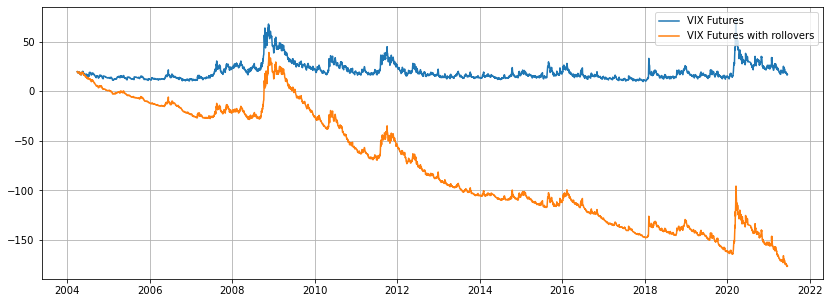

In [5]:
plt.figure(figsize=(14,5))
plt.plot(df['Close'], label='VIX Futures')
plt.plot(df['Close_n'], label='VIX Futures with rollovers')
plt.grid()
plt.legend(loc='upper right')
plt.show()


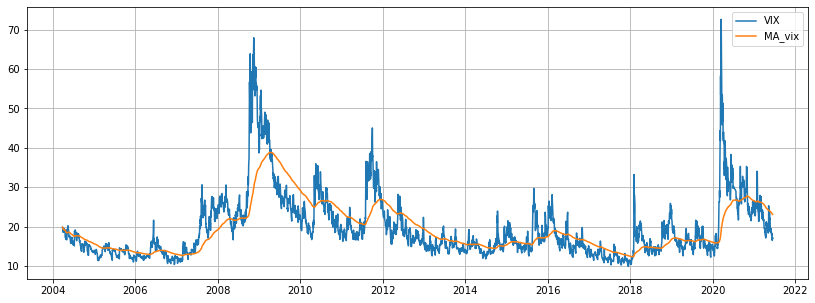

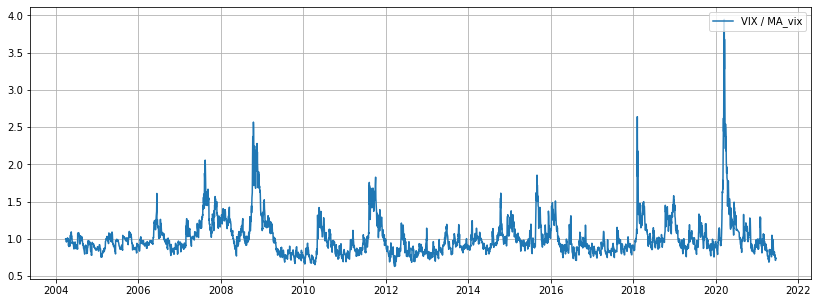

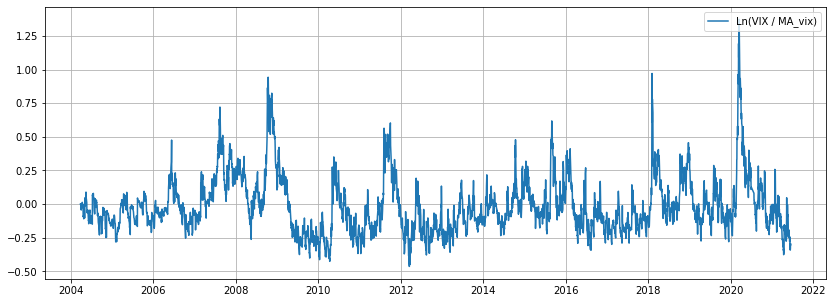

In [6]:
plt.figure(figsize=(14,5))
plt.plot(df['Close'], label='VIX')
plt.plot(df['Close'].ewm(span=252).mean(), label='MA_vix')
plt.grid()
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(14,5))
plt.plot(df['Close'] / df['Close'].ewm(span=252).mean(), label='VIX / MA_vix')
plt.grid()
plt.legend(loc='upper right')
plt.show()


plt.figure(figsize=(14,5))
plt.plot(np.log(df['Close'] / df['Close'].ewm(span=252).mean()), label='Ln(VIX / MA_vix)')
plt.grid()
plt.legend(loc='upper right')
plt.show()


In [7]:
def opt_vix_0(x, df):    
    """Функционал для оптимизации
        
        Parameters
        ----------
        x : np.array
            значения аргументов, по которым рассчитывается значение функционала
        df : pd.DataFrame
            датафрейм содержащий ряды signal, Close и dd_log
            
        Returns
        ------
        f : float
            значение функционала
        """

    x_levels = x[:-1]
    t = x[-1]

    # считаем сигнал
    df['pre_signal'] = np.log(df['Close'] / df['Close'].ewm(span=t).mean())
    
    # расчитываем уровни, на которые поделим значения цен VIX'a
    p_levels = np.linspace(df['pre_signal'].min(), df['pre_signal'].max(), len(x_levels))

    # преобразуем полученные массивы в функцию
    f_delta = interpolate.interp1d(p_levels, x_levels, kind='linear')
    
    # считаем результирующий сигнал
    df['signal'] = f_delta(df['pre_signal'])
    
    df = stupid_backtest_2(df)
    
    # просто максимум профита
    f = -df['pnl_comm'].iloc[-1]
    
    return f

In [8]:
def plot_solution(ga, df):

    x = ga.solution['args']
    x_levels = x[:-1]
    t = x[-1]



    print(t)


    df['pre_signal'] = np.log(df['Close'] / df['Close'].ewm(span=t).mean())
    p_levels = np.linspace(df['pre_signal'].min(), df['pre_signal'].max(), len(x_levels))
    f_delta = interpolate.interp1d(p_levels, x_levels, kind='linear')
    df['signal'] = f_delta(df['pre_signal'])

    plt.figure(figsize=(14,5))
    plt.plot(p_levels, x_levels)
    plt.grid()
    plt.xlabel('Signal')
    plt.ylabel('Position')
    plt.show()
    
    df = stupid_backtest_2(df)

    plt.figure(figsize=(14,5))
    plt.plot(df['signal'], label='signal')
    plt.grid()
    plt.legend(loc='upper right')
    plt.show()

    plt.figure(figsize=(14,5))
    plt.plot(df['pnl'], label='pnl')
    plt.plot(df['pnl_comm'], label='pnl_comm')
    plt.plot(-(df['Close_n'] - df['Close_n'].iloc[0]), label='buy and hold (with rollovers)')
    plt.grid()
    plt.legend(loc='upper right')
    plt.show()

In [9]:
args_bounds = [
    (-1.0, 1.0),
    (-1.0, 1.0),
    (-1.0, 1.0),
    (-1.0, 1.0),
    (-1.0, 1.0),
    (-1.0, 1.0),
    (-1.0, 1.0),
    (-1.0, 1.0),
    (-1.0, 1.0),
    (-1.0, 1.0),
    (20, 1000)
]

std stop-criterion
{'args': array([ 1.        , -1.        , -1.        , -1.        , -1.        ,
        1.        ,  1.        ,  0.98634032, -0.98907199, -1.        ,
       32.92535851]), 'score': -300.99688018294347}
32.92535850915787


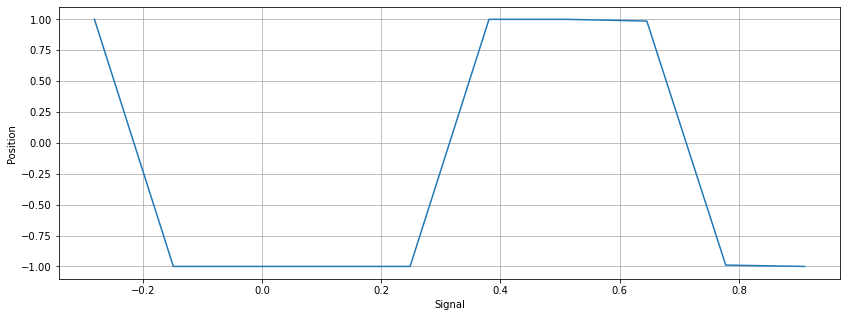

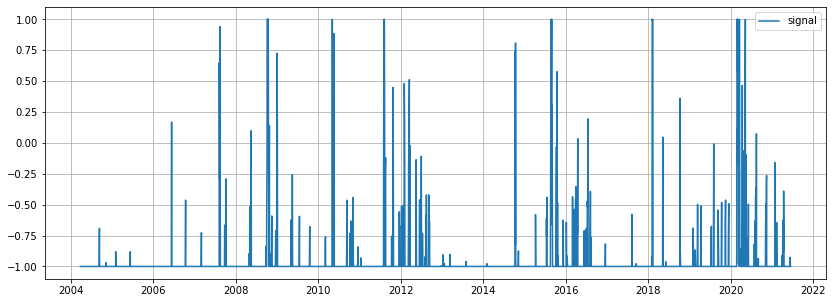

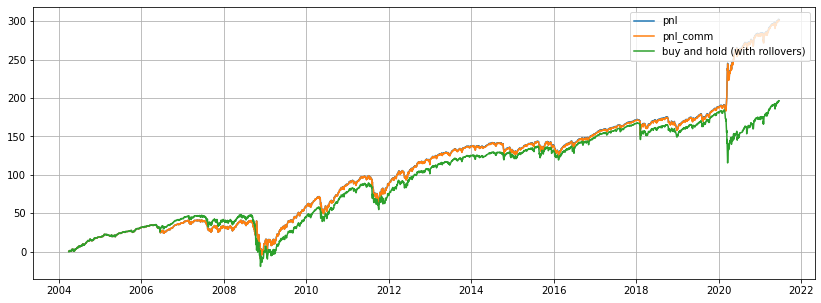

In [796]:
ga = GeneticAlgorithm(opt_vix_0, 11, df, args_bounds=args_bounds)
ga.run()

print(ga.solution)
plot_solution(ga, df)



In [797]:
class GARoulette(GeneticAlgorithm):
    
    def selection(self, population):
        """Метод для отбора особей
        
        Parameters
        ----------
        population : list
            популяция, содержит значения генов всех особей и оценки приспособленности
            
        Returns
        ------
        population : list
            популяция, содержит значения генов всех особей и оценки приспособленности
        """

        population_new = []
        
        for i in range(self.population_size):
            roulette_arr = np.cumsum([i['score'] for i in population])
            random_val = np.random.uniform(min(roulette_arr), 0)
            
            if len(roulette_arr[roulette_arr < random_val]) == 0:
                roulette_val = np.random.choice(roulette_arr)
            else:
                roulette_val = roulette_arr[roulette_arr < random_val][0]
            
            ind = np.where(roulette_arr == roulette_val)[0][0]

            population_new.append(population[ind])
            del population[ind]
            
            
        return population_new

std stop-criterion
{'args': array([ 0.89424263, -1.        , -0.91670416, -0.26359664,  0.15154703,
        1.        ,  1.        , -0.7332266 ,  1.        , -0.7312062 ,
       20.        ]), 'score': -180.52091123579052}
20.0


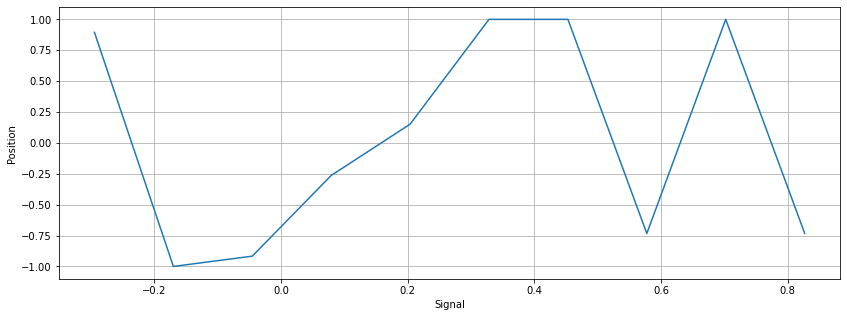

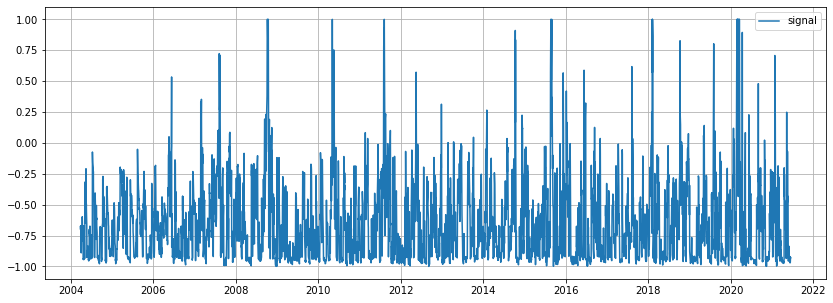

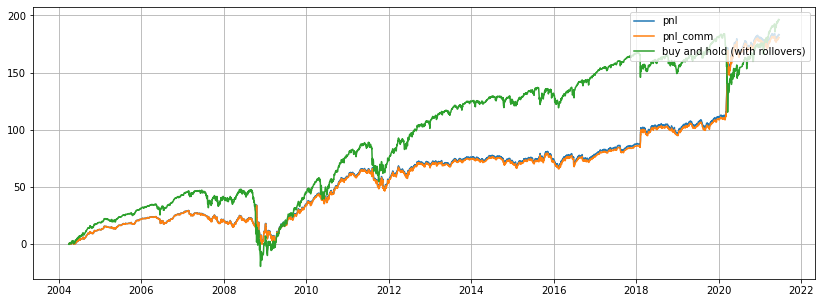

In [798]:
ga = GARoulette(opt_vix_0, 11, df, args_bounds=args_bounds)
ga.run()

print(ga.solution)
plot_solution(ga, df)



In [799]:
class GALinearRanking(GeneticAlgorithm):
    
    def selection(self, population):
        """Метод для отбора особей
        
        Parameters
        ----------
        population : list
            популяция, содержит значения генов всех особей и оценки приспособленности
            
        Returns
        ------
        population : list
            популяция, содержит значения генов всех особей и оценки приспособленности
        """

        population = sorted(population, key=lambda item: item['score'])
        
        population_new = []
        N = self.population_size
        p_list = []
        
        for i in range(1, N+1):
            a = np.random.uniform(1, 2)
            b = 2 - a
            p = 1 / N * (a - (a - b) * (i - 1) / (N - 1))
            
            if np.random.rand() / N <= p:
                population_new.append(population[i])
        
        population_new = population[:self.population_size]
        
        return population_new

std stop-criterion
{'args': array([ 0.99188846, -0.99883621, -0.9996786 , -0.99607816, -0.99861717,
        1.        , -0.97866272,  0.99317675, -0.99161763, -0.98083566,
       34.87147713]), 'score': -323.4140716487266}
34.87147713475678


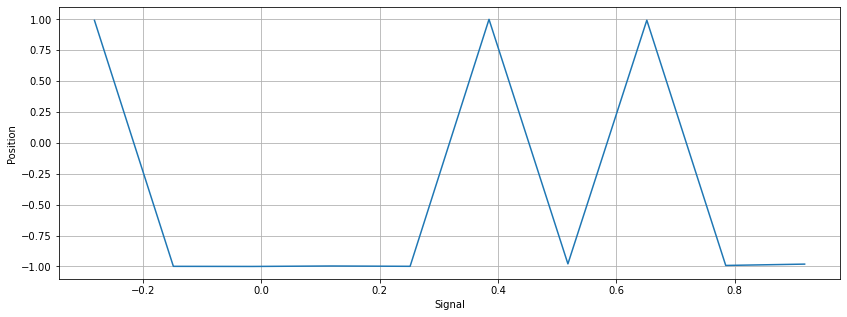

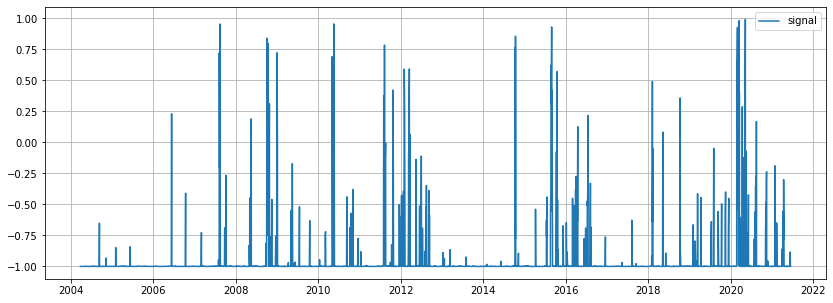

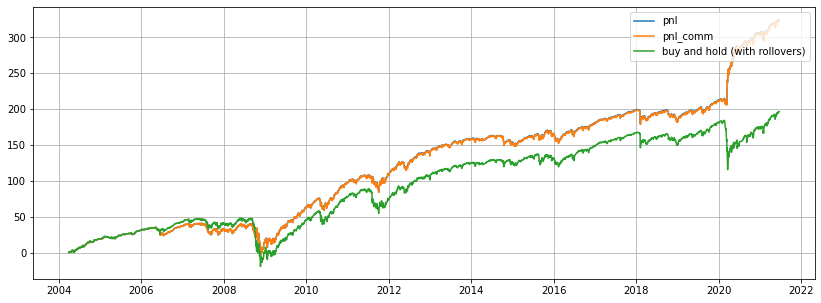

In [800]:
ga = GALinearRanking(opt_vix_0, 11, df, args_bounds=args_bounds)
ga.run()

print(ga.solution)
plot_solution(ga, df)



In [801]:
class GALocal(GeneticAlgorithm):
    
    def selection(self, population):
        """Метод для отбора особей
        
        Parameters
        ----------
        population : list
            популяция, содержит значения генов всех особей и оценки приспособленности
            
        Returns
        ------
        population : list
            популяция, содержит значения генов всех особей и оценки приспособленности
        """
        
        population = sorted(population, key=lambda item: item['score'])
        population = population[:int(0.75 * self.population_size)]
        
        population_new = []
        
        for i in range(self.population_size):
            ind = np.random.choice(population)
            population_new.append(ind)
                
        return population_new
    
    
    def run(self):
        
        # создаем начальную популяцию
        population = []
        for i in range(self.population_size):
            args_individual = np.zeros(self.num_args)
            # нормируем значения аргументов к границам args_bounds, если они заданы
            for n in range(self.num_args):
                if self.args_bounds is None:
                    args_individual[n] = np.random.uniform(-1.0, 1.0)
                else:
                    args_individual[n] = np.random.uniform(self.args_bounds[n][0], self.args_bounds[n][1])
                    
            # вычисляем приспособленность особи
            score = self.estimate_fitness(args_individual)
            individual = {'args':args_individual, 'score':score}
            population.append(individual)
           
        stop = False
        i = 0
        # запускаем алгоритм
        while not stop:
            
            # СКРЕЩИВАНИЕ
            parents_population = np.random.choice(population, int(len(population) * self.crossover_rate))
            
            childs_population = []
            for x_parent in parents_population:
                # отбираем соседей по принципу корреляции координат 
                neighbors = [i for i in population if np.corrcoef(x_parent['args'], i['args'])[0,1] > 0.3]
                # находим пару для каждой особи и проводим скрещиванием
                y_parent = np.random.choice(neighbors)
                x_child_args, y_child_args = self.crossover(x_parent['args'], y_parent['args'])
                x_child = {'args':x_child_args, 'score':None}
                y_child = {'args':y_child_args, 'score':None}
                childs_population.append(x_child)
                childs_population.append(y_child)
            # добавляем новых потомков в популяцию
            population += childs_population

            # МУТАЦИИ
            for ind, x in enumerate(population):
                # проверяем условие вероятности мутации
                if np.random.rand() < self.mutation_probability:
                    population[ind]['args'] = self.mutation(x['args'])
            
            # ОЦЕНКА ПРИСПОСОБЛЕННОСТИ
            for ind in range(len(population)):
                population[ind]['args'] = self.keep_bounds(population[ind]['args'])
                population[ind]['score'] = self.estimate_fitness(population[ind]['args'])
                
            # ОТБОР
            population = self.selection(population)
            
            # записываем best_score 
            best_score = population[0]['score']
            self.best_score_history.append(best_score)
            
            if i > 10:
                stop = self.stop_criterion(i)
            
            i += 1
            
        self.solution = population[0]

std stop-criterion
{'args': array([ 0.63362824, -0.21291777, -0.98301238, -0.9954723 , -0.91059524,
        0.18854235,  1.        , -0.77959007,  0.38553111, -0.93804326,
       20.        ]), 'score': -258.94551305028335}
20.0


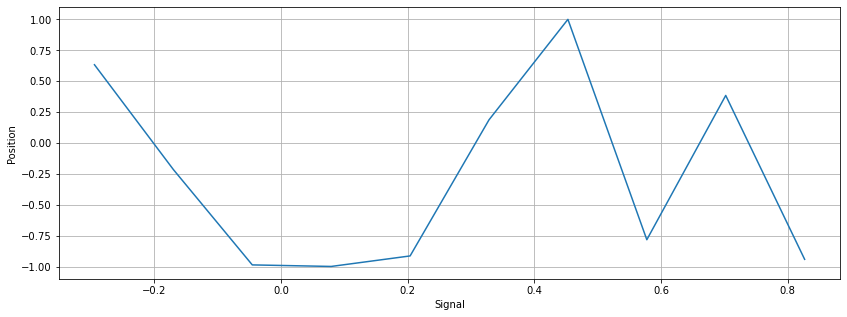

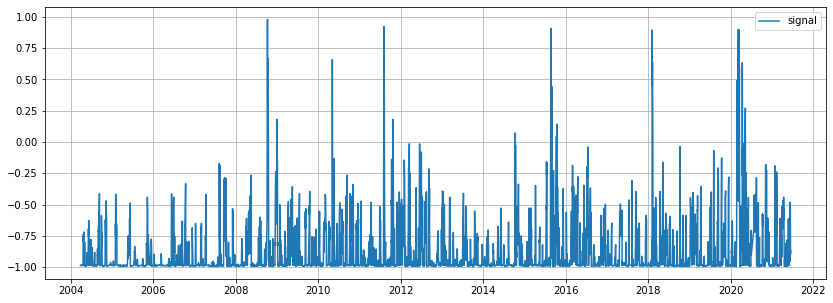

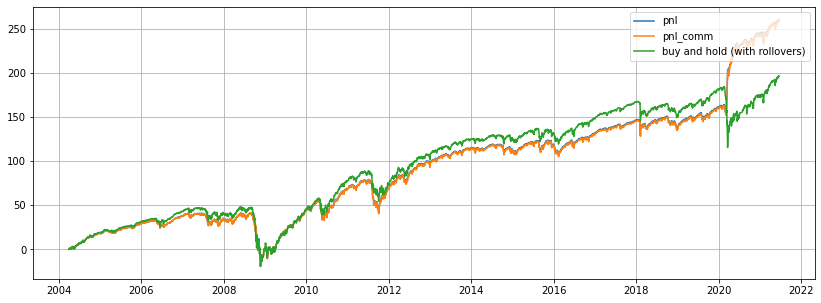

In [802]:
ga = GALocal(opt_vix_0, 11, df, args_bounds=args_bounds)
ga.run()

print(ga.solution)
plot_solution(ga, df)



In [803]:
class GATruncation(GeneticAlgorithm):
    
    def selection(self, population):
        """Метод для отбора особей
        
        Parameters
        ----------
        population : list
            популяция, содержит значения генов всех особей и оценки приспособленности
            
        Returns
        ------
        population : list
            популяция, содержит значения генов всех особей и оценки приспособленности
        """
        
        population = sorted(population, key=lambda item: item['score'])
        population = population[:int(0.75 * self.population_size)]
        
        population_new = []
        
        for i in range(self.population_size):
            ind = np.random.choice(population)
            population_new.append(ind)
                
        return population_new

std stop-criterion
{'args': array([-9.10113690e-01, -9.16254007e-01, -1.00000000e+00, -9.85947582e-01,
       -1.00000000e+00, -1.00000000e+00,  9.16321794e-01,  1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00,  1.00000000e+03]), 'score': -250.05150868992763}
1000.0


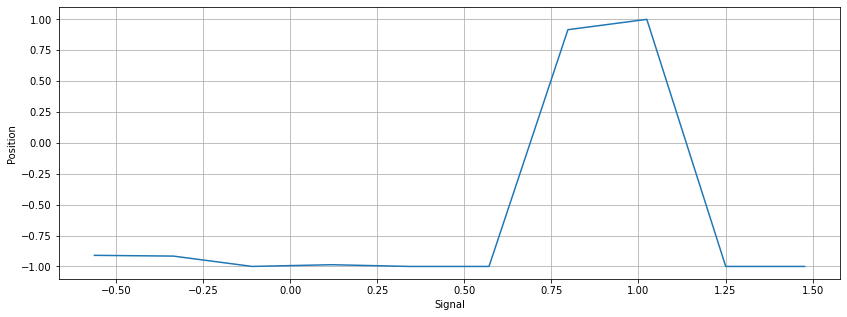

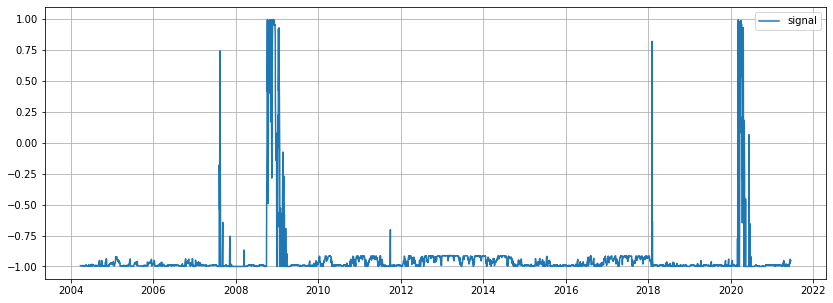

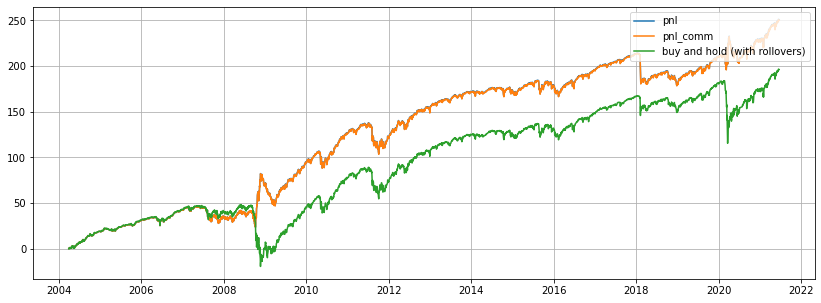

In [804]:
ga = GATruncation(opt_vix_0, 11, df, args_bounds=args_bounds)
ga.run()

print(ga.solution)
plot_solution(ga, df)



In [805]:
class GATournament(GeneticAlgorithm):
    
    def selection(self, population):
        """Метод для отбора особей
        
        Parameters
        ----------
        population : list
            популяция, содержит значения генов всех особей и оценки приспособленности
            
        Returns
        ------
        population : list
            популяция, содержит значения генов всех особей и оценки приспособленности
        """
        
        population_new = []
        
        for i in range(self.population_size):
            ind_0 = np.random.choice(population)
            ind_1 = np.random.choice(population)
            ind_res = sorted([ind_0, ind_1], key=lambda item: item['score'])[0]
            
            population_new.append(ind_res)
                
        return population_new

std stop-criterion
{'args': array([-3.37408816e-01, -5.38487233e-01, -9.99929263e-01, -1.00000000e+00,
       -1.00000000e+00, -1.00000000e+00,  1.00000000e+00, -1.60032176e-01,
       -9.17829998e-01,  1.00000000e+00,  8.42093880e+02]), 'score': -215.26720952025508}
842.093880245174


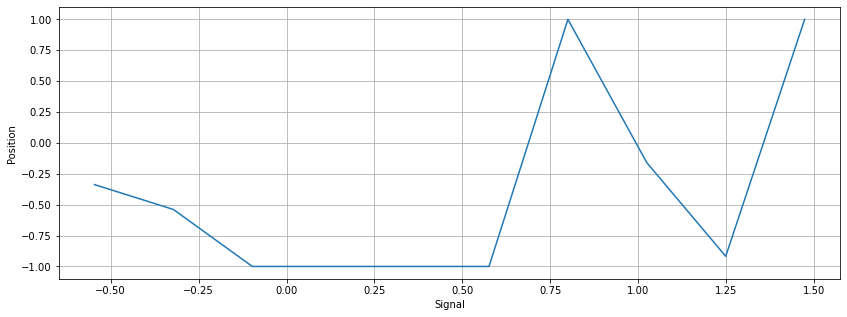

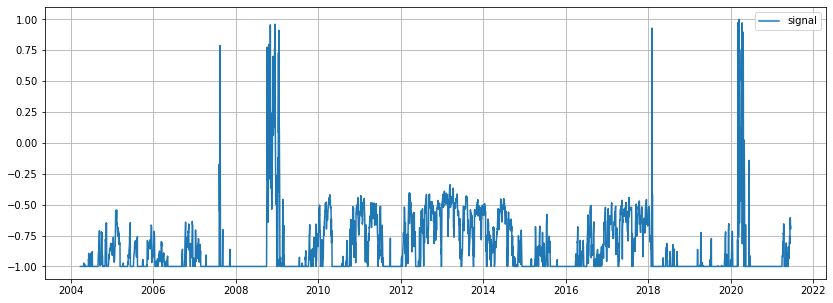

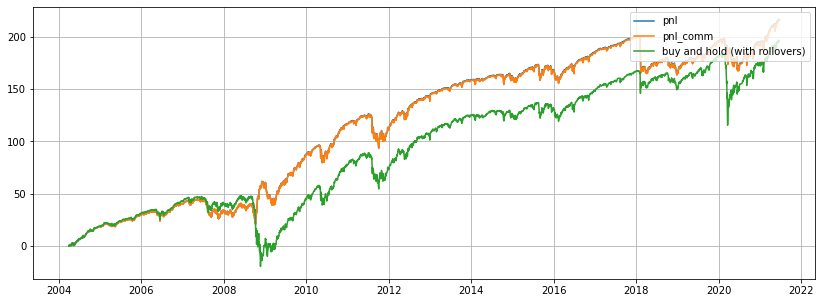

In [806]:
ga = GATournament(opt_vix_0, 11, df, args_bounds=args_bounds)
ga.run()

print(ga.solution)
plot_solution(ga, df)

